In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
from src.d05_regression_model import Trainer

torch.use_deterministic_algorithms(True) 

W1004 21:46:53.745000 59472 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
trainer = Trainer('cuda', tracking=True, experiment='Assembly Inspector Counter')

In [3]:
#model = trainer.train_model(folder='./data/temp/counting_imgs/screwdriver/scale_0.35', part='screwdriver', num_in_assembly=1)

In [ ]:
model = trainer.train_model(folder='./data/temp/counting_imgs/wheels_five/scale_0.2', part='screw', num_in_assembly=5)

imgs_per_class 255
Training...


In [ ]:
from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torchvision.transforms.v2 as transforms
import random
import matplotlib.patches as patches
from mlflow import MlflowClient
import mlflow
import os
import torch
from src.d02_binary_model import Trainer, CustomImageFolder
os.environ["MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR"] = "false"
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")


def gradcam(path, part, l_idx, img_idx=None, img_folder=None, model_name=None, model_version=None):
    if model_name is None:
        model_name = path[:path.rfind(part)+len(part)]
        model_name = model_name.replace("/", "_")
        model_name += "_counter"
    client = MlflowClient()
    if model_version is None:
        model_version = client.search_model_versions(f'name="{model_name}"')[0].version
    
    model = mlflow.pytorch.load_model(f'models:/{model_name}/{model_version}').to('cpu') 
    model.eval()    

    img_channels = Trainer.get_img_shape(f"{path}/0")[0]
    transform = transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize([0.5] * img_channels, [0.5] * img_channels),
        ]
    )

    if img_folder is not None:
        path = img_folder

    ds = CustomImageFolder(path, transform=transform)
    if img_idx is None:
        img_idx = random.randint(0, len(ds) - 1)

    input_tensor = ds[img_idx][0].unsqueeze(0)

    img = ds[img_idx][0] * 0.5 + 0.5
    img = img.clamp(0, 1)

    if img_channels == 1:
        img = img.squeeze(0).numpy()  # shape (H, W)
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # shape (H, W, 3)
    else:
        img = img.permute(1, 2, 0).numpy()
    
    #print(model.layers)
    target_layers = [model.layers.features[l_idx]]#[2]
    
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)  
    targets = [ClassifierOutputTarget(0)]
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  
    grayscale_cam = grayscale_cam / (grayscale_cam.max()+1e-8)
    
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    
    f, ax = plt.subplots(1, 2, figsize=(10, 5))  # (40, 20))
    ax[0].imshow(visualization, cmap="jet")
    ax[1].imshow(grayscale_cam, cmap="jet")
    #plt.imshow(visualization, cmap='jet')
    #plt.imshow(grayscale_cam, cmap='jet')

    plt.tight_layout()
    plt.show()

In [ ]:
tests = []
tests.append(["./data/temp/counting_imgs/wheels_five/scale_0.2/screw/2_3/h", "screw", [1000]])
tests.append(["./data/temp/counting_imgs/wheels_five/scale_0.2/screw/2_3/h", "screw", [1000], "./data/temp/wheels_five/scale_0.2/"])
tests.append(["./data/temp/counting_imgs/wheels_five/scale_0.2/screw/2_3/h", "screw", [100], "./data/temp/wheels_five/scale_0.2/"])
tests.append(["./data/temp/counting_imgs/wheels_five/scale_0.2/screw/2_3/h", "screw", [1400], "./data/temp/wheels_five/scale_0.2/"])

for i in range(13):
    for tst in tests:
        print(tst[0], tst[1])
        if type(tst[2]) != list:
            tst[2] = [tst[2]]        
        real_files = None
        if len(tst) > 3:
            real_files = tst[3]
        for pic in tst[2]:
            print(i, pic)
            gradcam(tst[0], tst[1], i, pic, real_files)

In [6]:
dls= trainer.get_dataloaders('./data/temp/counting_imgs/wheels_five/scale_0.2/screw', [3, 672, 378], 5, 'screw')

imgs_per_class 255


Samples amount: 253


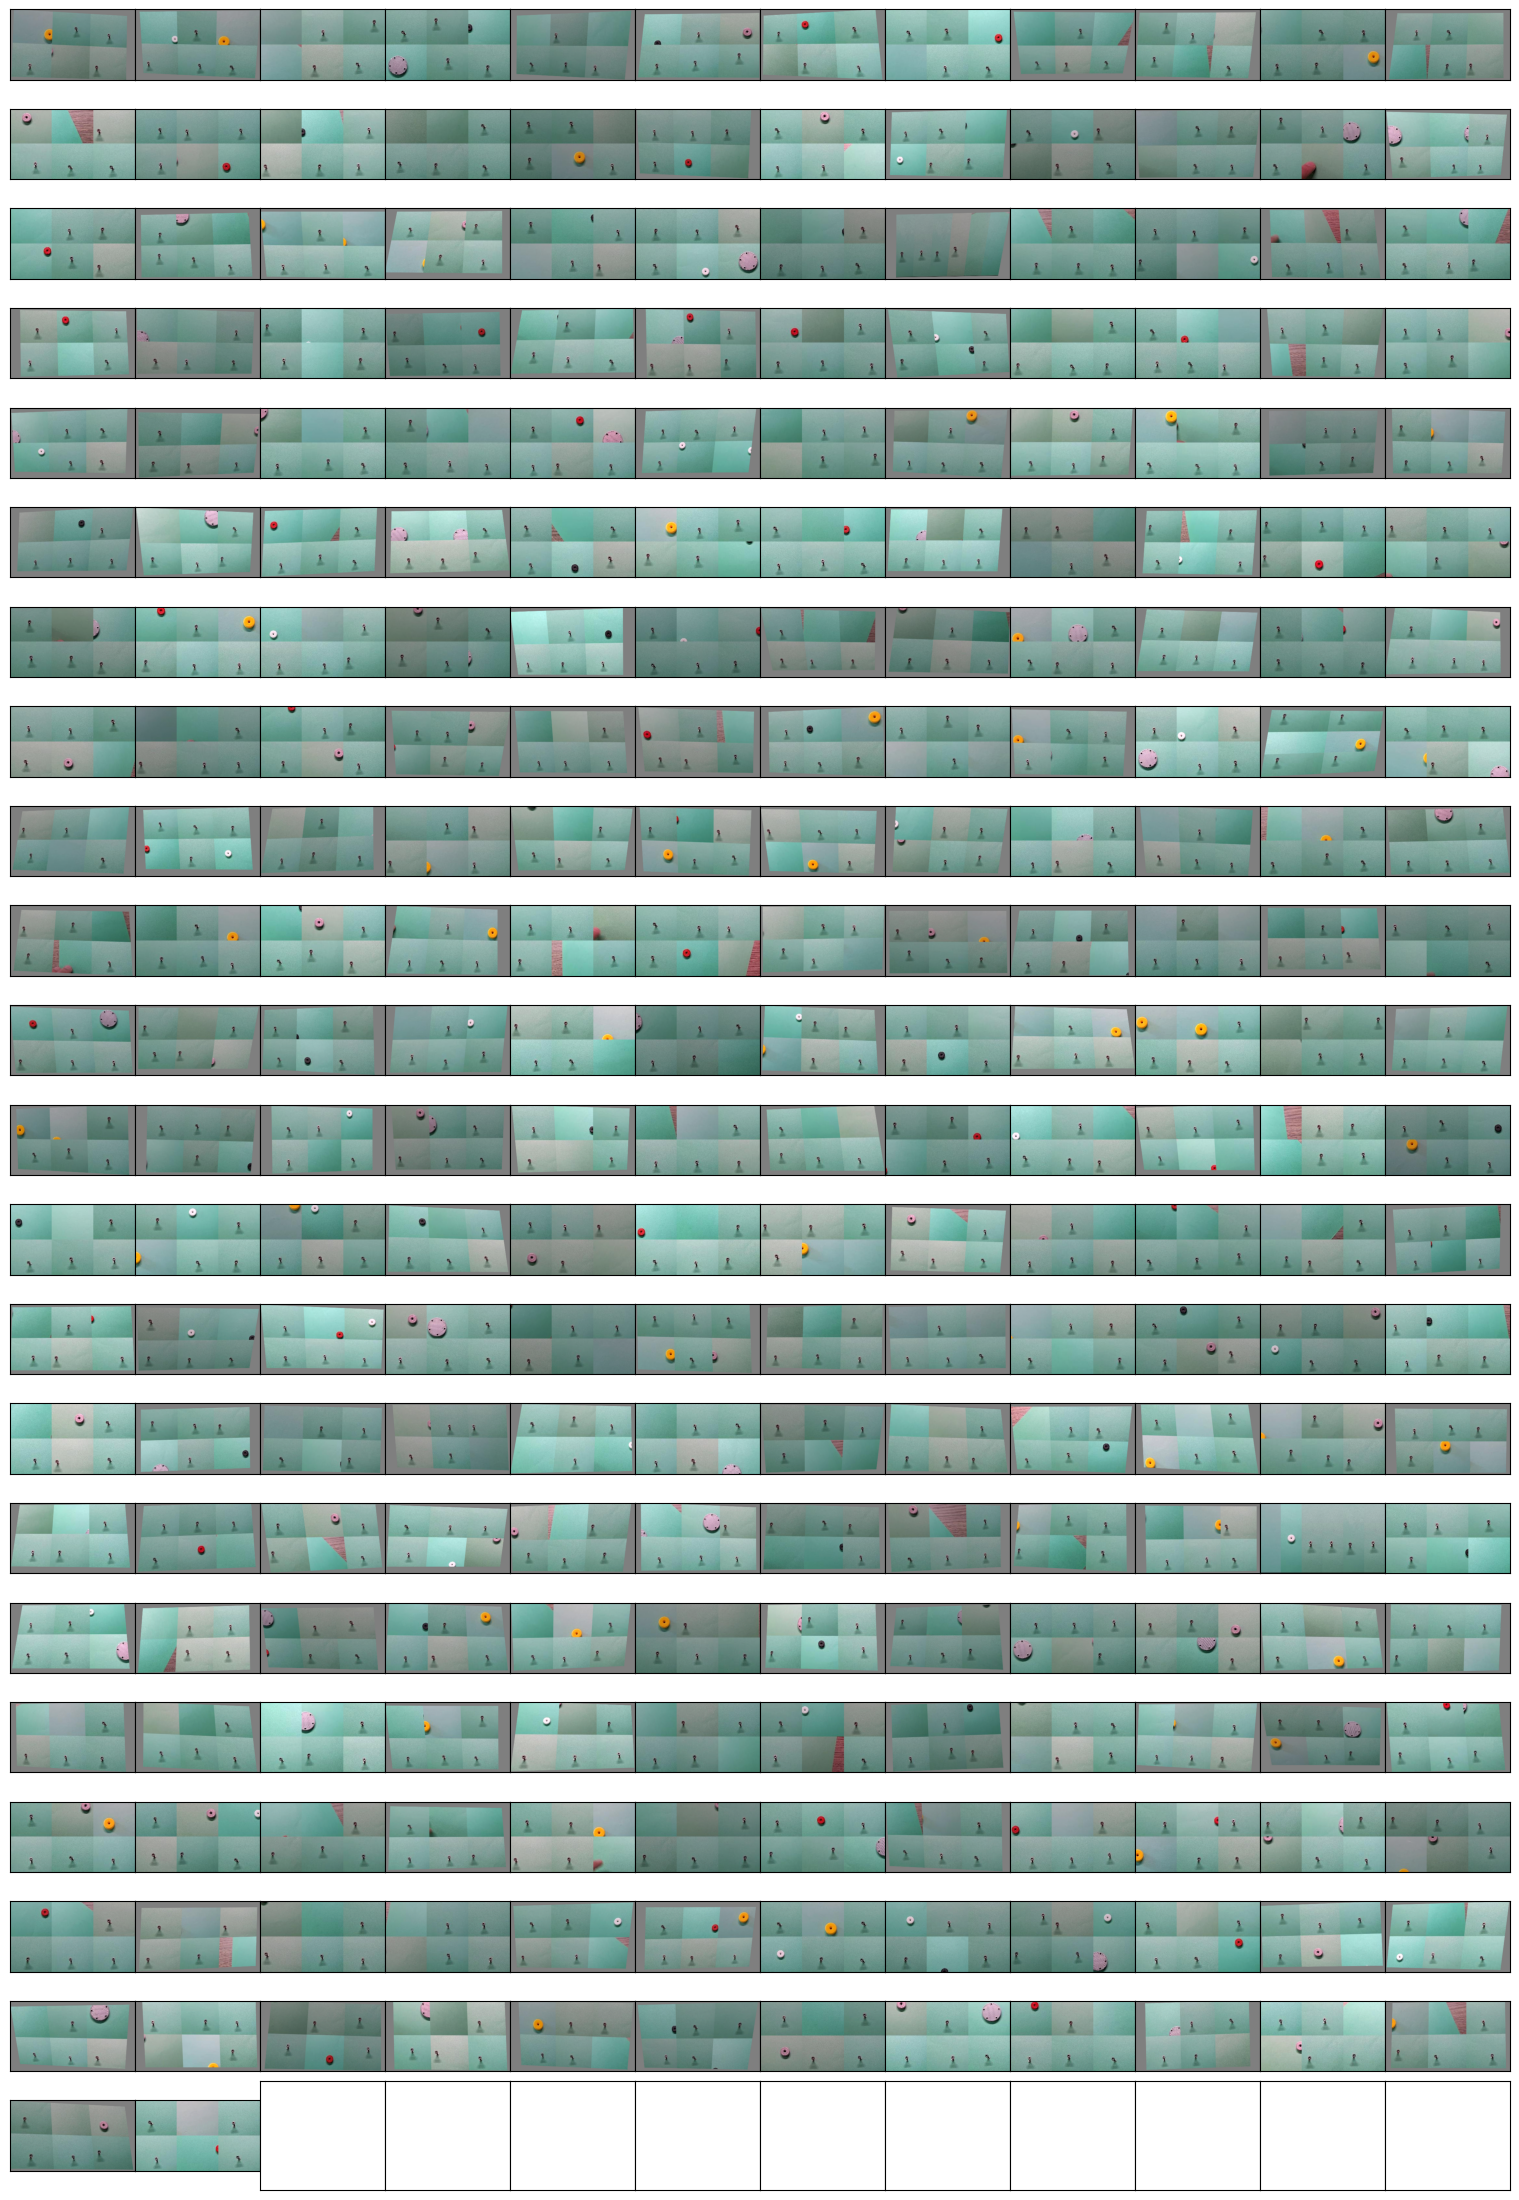

In [11]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
#from PIL import Image
from torchvision.transforms.functional import to_pil_image
import math

def show_target_imgs(loader: DataLoader, target):
    _COLUMNS = 12
    imgs_num = 0
    
    for X, y in loader:
        for one_y in y:
            if one_y == target:
                imgs_num += 1
    print("Samples amount:", imgs_num)            

    rows = math.ceil(imgs_num / _COLUMNS)
    if rows in (0, 1):
        rows = 2

    f, ax = plt.subplots(rows, _COLUMNS, figsize=(15, 1*rows))

    for plot in ax.ravel():
        plot.set_xticks([])
        plot.set_yticks([])

    num = 0
    for X, y in loader:
        for i in range(len(X)):
            if y[i] == target:
                ax[num // _COLUMNS, num % _COLUMNS].imshow(to_pil_image(X[i]*0.5 + 0.5, mode="RGB"))
                num += 1

    plt.tight_layout(pad=0)
    plt.show()

show_target_imgs(dls['train'], 4/6)

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as transforms

normalize_arg = [0.5] * 3
img_transforms = transforms.Compose([transforms.ToImage(),
                    transforms.ToDtype(torch.float32, scale=True),
                    transforms.Normalize(normalize_arg, normalize_arg)])
ds = ImageFolder(root = "./data/check/wheels_five/scale_0.2/screw", transform=img_transforms,allow_empty=True)
dl = DataLoader(ds, batch_size=1000)

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
#from PIL import Image
from torchvision.transforms.functional import to_pil_image
import math
import mlflow
from torch import nn

def show_failed_imgs(loader: DataLoader, model_name:str, mlflow_url:str = "http://127.0.0.1:8080"):
    _COLUMNS = 6

    mlflow.set_tracking_uri(uri=mlflow_url)  
    model = mlflow.pytorch.load_model(f'models:/{model_name}').to('cpu') 

    targets = []
    fails = []    
    
    for X, y in loader:
        pred = model(X)
        pred = nn.functional.softmax(pred, 1)
        
        for i in range(len(y)):
            print(torch.round(pred[i]))
            if pred[i, y[i]] < 0.5 or torch.sum(pred[i] > 0.5) > 1:
                if y[i] not in targets:
                    targets.append(y[i])
                    fails.append([])
                
                fails[targets.index(y[i])].append(X[i])

    print("Fails:", sum([len(l) for l in fails])) 

    for i in range(len(targets)):
        print("Target:", targets[i].item())      

        rows = math.ceil(len(fails[i]) / _COLUMNS)
        if rows in (0, 1):
            rows = 2

        f, ax = plt.subplots(rows, _COLUMNS, figsize=(15, 2*rows))

        for plot in ax.ravel():
            plot.set_xticks([])
            plot.set_yticks([])
        
        for i2 in range(len(fails[i])):
            ax[i2 // _COLUMNS, i2 % _COLUMNS].imshow(to_pil_image(fails[i][i2]*0.5 + 0.5, mode="RGB"))

        plt.tight_layout(pad=0)
        plt.show()
show_failed_imgs(dl, model_name="._data_temp_counting_imgs_wheels_five_scale_0.2_screw_counter/35")
#show_failed_imgs(dls['test'][0], model_name="._data_temp_counting_imgs_wheels_five_scale_0.2_screw_counter/35")